# ICEBERG Fragmentation Analysis (on NIST'20 test dataset)

This notebook provides scripts to plot the analyzed fragmentation data as heatmaps. Please download the pickle files for the pre-processed dat (from the branch `feat/bond-analysis` `notebooks/iceberg_analysis_fragmentation.ipynb`)

In [1]:
# Import libraries

import ast
from collections import defaultdict
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
import pickle
from ms_pred import common

import matplotlib

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#7B94CC', '#FFD593'])
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#fafbfd', '#5172bc']) # blue
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#e1e7eb', '#6d879b'])
common.plot_utils.set_style()

# Other colors:
# D7D7D7 A7B7C3 7C9D97 7B94CC FFD593 E9B382

In [2]:
# Path where pickle files are stored
# SAVE_PATH = "/home/magled/results/20241129"
SAVE_PATH = "/home/magled/results/20241024_dft/"
# Relevant files:

# load data_frames, collision_energies, bond_types from a file
with open(f"{SAVE_PATH}/data_frames.pkl", 'rb') as f:
    data_frames = pickle.load(f)

with open(f"{SAVE_PATH}/collision_energies.pkl", 'rb') as f:
    collision_energies = pickle.load(f)

with open(f"{SAVE_PATH}/bond_types.pkl", 'rb') as f:
    bond_types = pickle.load(f)

In [3]:
data_frames

{'absolute_counts':          C~N     C~O    N~O      C~C    N~N   O~O
 1.0   570958  585159  24042  1209235  44725  2692
 5.0   578062  586640  24599  1224264  45419  2751
 10.0  588351  590418  25177  1242258  46520  2737
 20.0  597588  599205  25503  1265136  47410  2661
 30.0  607289  610835  25152  1299155  47324  2553
 50.0  620505  618065  24355  1344732  46629  2442,
 'intensity_score':             C~N        C~O       N~O        C~C       N~N       O~O
 1.0   14.216968  44.838006  1.080040  37.852680  1.780141  0.232166
 5.0   13.267486  40.717833  1.148213  43.147206  1.512310  0.206952
 10.0  13.428692  34.009831  1.222148  49.670439  1.500244  0.168646
 20.0  15.739819  26.436317  1.201350  54.888037  1.615678  0.118799
 30.0  18.567464  21.062538  1.078170  57.592439  1.633980  0.065409
 50.0  20.368691  17.392605  0.829477  59.974255  1.397078  0.037894,
 'frequency_score':            C~N       C~O       N~O       C~C       N~N       O~O
 1.0   1.289117  1.335032  1.594835

In [4]:
collision_energies

[1.0, 5.0, 10.0, 20.0, 30.0, 50.0]

In [5]:
bond_types

['C~C', 'C~N', 'C~O', 'N~N', 'N~O', 'O~O']

In [6]:
# only take data_frames data from the 10 most abundant bond types (highest 'bond_occurences')
bond_occurences = data_frames['bond_occurences']

# take the 10 columns with the highest values in second row
top_bond_types = bond_occurences.iloc[1].nlargest(10).index

# specify most common C, N, O bonds
# top_bond_types = ['C~C', 'C~N', 'C~O', 'N~N', 'N~O', 'O~O']

# for every df which is a value from data_frames, only take the columns from top_bond_types
top_data_frames = {k: v[top_bond_types] for k, v in data_frames.items()}

# norm each row
top_data_frames['preferential_score'] = top_data_frames['preferential_score'].div(top_data_frames['preferential_score'].sum(axis=1), axis=0) * 100
top_data_frames

{'absolute_counts':           C~C     C~N     C~O    N~N    N~O   O~O
 1.0   1209235  570958  585159  44725  24042  2692
 5.0   1224264  578062  586640  45419  24599  2751
 10.0  1242258  588351  590418  46520  25177  2737
 20.0  1265136  597588  599205  47410  25503  2661
 30.0  1299155  607289  610835  47324  25152  2553
 50.0  1344732  620505  618065  46629  24355  2442,
 'intensity_score':             C~C        C~N        C~O       N~N       N~O       O~O
 1.0   37.852680  14.216968  44.838006  1.780141  1.080040  0.232166
 5.0   43.147206  13.267486  40.717833  1.512310  1.148213  0.206952
 10.0  49.670439  13.428692  34.009831  1.500244  1.222148  0.168646
 20.0  54.888037  15.739819  26.436317  1.615678  1.201350  0.118799
 30.0  57.592439  18.567464  21.062538  1.633980  1.078170  0.065409
 50.0  59.974255  20.368691  17.392605  1.397078  0.829477  0.037894,
 'frequency_score':            C~C       C~N       C~O       N~N       N~O       O~O
 1.0   0.801910  1.289117  1.335032

In [7]:
# Metrics to plot
metrics_to_look_at = [
                      'absolute_counts',
                      'intensity_score',
                      'frequency_score',
                      'preferential_score',
                      'i_times_f_score',
                      'bond_occurences'
                      ]


In [8]:
def plot_heatmap(grouped_data, collision_energies, bond_types, result_type, 
                with_environment=False, figsize=(20,20)):
    plt.figure(figsize=figsize)
    
    # Ensure data is sorted by collision energy
    grouped_data = grouped_data.sort_index()
    
    # Replace NaN with 0
    grouped_data = grouped_data.fillna(0)
    
    # Create a copy of the data for display
    display_data = grouped_data.copy()
    
    # Special handling for different metrics
    if result_type in ['bond_occurences', 'absolute_counts']:
        fmt = '.2f'  # Changed to show decimals for scaled values
        title = 'Bond Count in Structure (×10³)' if result_type == 'bond_occurences' else 'Absolute Counts (×10³)'
        # Scale values by 1000
        display_data = grouped_data / 1000
    else:
        if result_type in ['preferential_score', 'intensity_score']:
            # Replace columns that are all zeros with NaN
            zero_cols = grouped_data.columns[grouped_data.sum() == 0]
            display_data[zero_cols] = np.nan
        if result_type == 'preferential_score':
            fmt = '.1f'
        else:
            # Choose format based on values
            fmt = '.0f' if np.all(grouped_data.values % 1 == 0) else '.2f'
        title = f'{result_type.replace("_", " ").capitalize()}'
    
    # Create heatmap
    sns.heatmap(display_data, 
                cmap=cmap,
                annot=True,
                annot_kws={'fontsize': 6},
                fmt=fmt,
                cbar_kws={'label': title},
                mask=display_data.isna())
    
    plt.xlabel('Bond type')
    plt.ylabel('Structure' if result_type == 'bond_occurences' else 'Collision energy (eV)')
    
    if with_environment:
        plt.xticks(rotation=90, ha='right')
    else:
        plt.xticks(rotation=45, ha='right')
        offset = matplotlib.transforms.ScaledTranslation(3/72, 0, plt.gcf().dpi_scale_trans)
        # apply offset transform to all x ticklabels.
        for label in plt.gca().xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
    
    plt.tight_layout()
    plt.savefig(f'../results/figs_iceberg/{result_type}.pdf')
    plt.show()

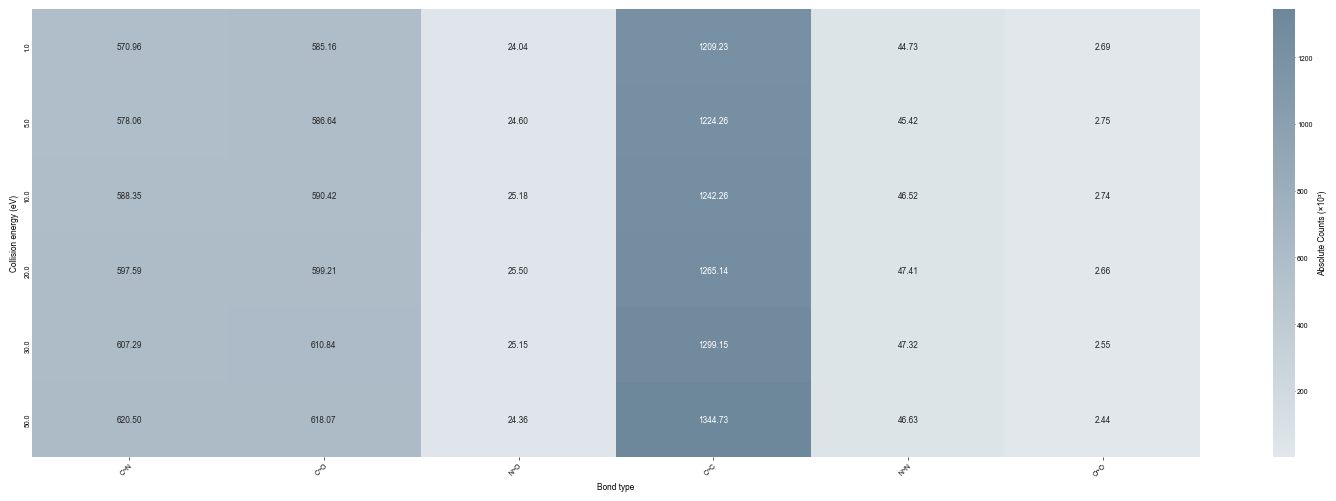

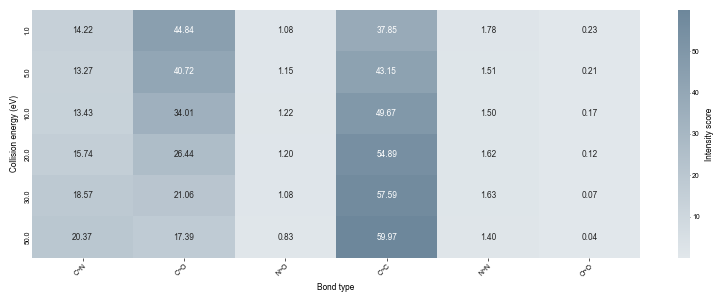

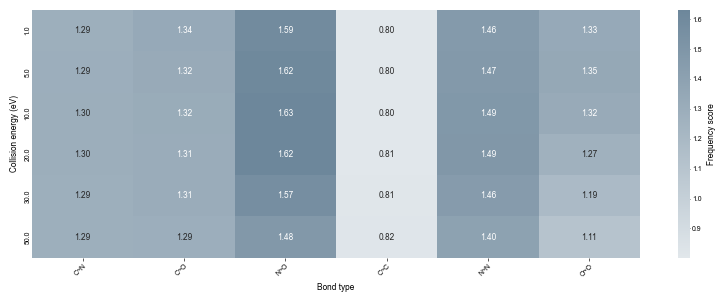

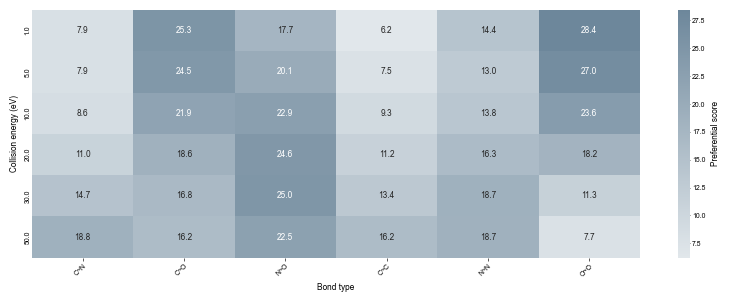

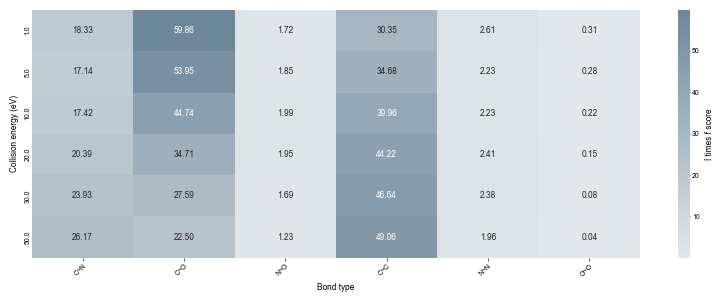

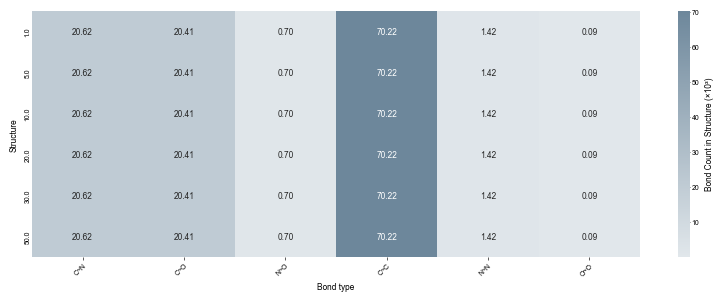

In [9]:
# plot heatmap
for result_type in metrics_to_look_at:
    if result_type == 'absolute_counts':
        figsize = (15,5)
    else:
        figsize = (8, 3)
    plot_heatmap(data_frames[result_type], collision_energies, bond_types, result_type, figsize=figsize)

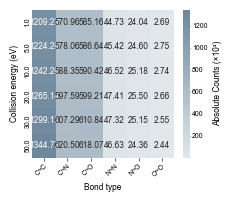

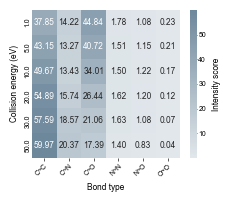

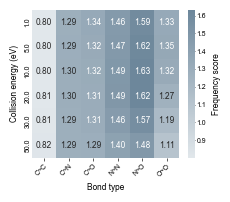

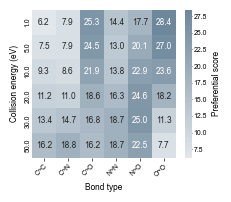

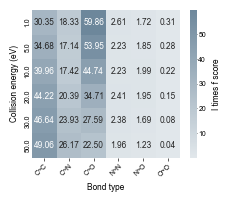

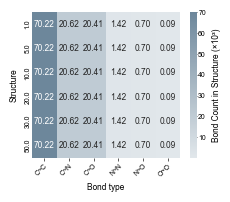

In [11]:
# plot heatmap
for result_type in metrics_to_look_at:
#     if result_type == 'absolute_counts':
#         figsize = (10,5)
#     else:
    figsize = (2.3, 2.)
    plot_heatmap(top_data_frames[result_type], collision_energies, top_bond_types, result_type, figsize=figsize)
